In [1]:
import math
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import os
import torch
import sentence_transformers
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import torch.nn as nn

from transformers import BertTokenizer, BertModel, pipeline, BartModel
from transformers import RobertaTokenizer, RobertaModel, AutoConfig
from transformers import AutoTokenizer, AutoModel

from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from DeBERTa import deberta
from collections import OrderedDict

import textstat

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
model_name = 'roberta-base'
size = 768

In [4]:
def config_model():
    configuration = AutoConfig.from_pretrained(model_name)

    configuration.hidden_dropout_prob = 0.0
    configuration.attention_probs_dropout_prob = 0.0
    configuration.classifier_dropout = 0.0
    
    return configuration

In [5]:
# ROBERTa model

# tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)
embeddings_model = RobertaModel.from_pretrained(model_name, config=config_model())


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data

In [6]:
summaries_train_path = r"dataset\summaries_train_merged.csv"
summaries_test_path = r"dataset\summaries_test.csv"
prompts_train_path = r"dataset\prompts_train.csv"
prompts_test_path = r"dataset\prompts_test.csv"

In [7]:
def norm_score(df: pd.DataFrame) -> pd.DataFrame:
    """Normilizing score to values 0 to 1"""
    df -= np.min(df)
    df /= df.max()
    print('Normilized' if df.min() == 0.0 and df.max() == 1.0 else 'NormError:wrong values')
    
    return df

def short_text(text, max_length=200) -> str:
    if len(text.split()) > 700:
        middle_point = text[len(text)//2:].index('.') + len(text)//2 + 1
        text_pt1 = text[:middle_point]
        text_pt2 = text[middle_point:]
        
        text = short_text(text_pt1) + short_text(text_pt2)

    summarizer = pipeline("summarization", model="bart-large-cnn")

    # summarizer.model.to(device)

    summarized = summarizer(text, max_length=max_length, min_length=80, do_sample=False)
    
    return summarized[0]['summary_text']

def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """
    
    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))
        
    return average_array


def mean_pooling(outputs, batch) -> torch.tensor:
    
    attention_mask = batch['attention_mask']
    embeddings = outputs.last_hidden_state
    
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
    mean_pooled = summed/summed_mask
    
    return mean_pooled

def normilize(df_column: pd.DataFrame):
    
    df_column = (df_column - df_column.mean())/df_column.std()
    
    return df_column

def get_cos_sim(df):
    sentence_1 = df.text
    sentence_2 = df.prompt_text

    sentence_tokenizer = AutoTokenizer.from_pretrained('all-mpnet-base-v2')
    sentence_model = AutoModel.from_pretrained('all-mpnet-base-v2')

    cos_sim_list = []
    sentence_model.to(device)

    for i, summarie in enumerate(tqdm(sentence_1)):
        prompt = sentence_2[i]
        inputs = sentence_tokenizer([summarie, prompt], padding=True,
                                    return_tensors='pt', truncation=True)
        inputs.to(device)

        with torch.no_grad():
            outputs = sentence_model(**inputs)

        sentence_embeddings = mean_pooling(outputs, inputs)
        sentence_embeddings = F.normalize(sentence_embeddings)

        score = nn.CosineSimilarity(dim=0)(sentence_embeddings[0], sentence_embeddings[1])

        cos_sim_list.append(score.item())

    return cos_sim_list

def get_stat_features(df, text_col="text"):
    
    df["num_unique_words"] = normilize(df[text_col].apply(lambda x: len(set(x.split()))))
    df["num_words"] = normilize(df[text_col].apply(lambda x: len(x.split())))
    df["num_sentences"] = normilize(df[text_col].apply(lambda x: len(x.split('.'))))
    
    df["syntax_count"] = normilize(df[text_col].apply(lambda x: x.count(",") 
                                                      + x.count("-") + x.count(";") + x.count(":")))
    df['smog_index'] = normilize(df[text_col].apply(lambda x: textstat.smog_index(x)))
    # df['cos_sim'] = normilize(pd.DataFrame(get_cos_sim(df)))
    
    return df

In [8]:
# with open(prompts_train_path, encoding='utf-8') as f:
#     prompts = pd.read_csv(f)
#     for i, text in enumerate(prompts.prompt_text):
#             if len(text.split()) > 300:
#                 prompts.prompt_text[i] = short_text(text)
#
# with open(summaries_train_path, encoding='utf-8') as f:
#     summaries = pd.read_csv(f)
#     summaries = summaries.merge(prompts, how="left", on="prompt_id")
#     summaries = get_stat_features(summaries)

In [9]:
class SentenseData(Dataset):
    """
    :params: path to csv file with summaries, path to csv file with prompts, 'score' param\
    defines which score is used: content/wording
    """
    def __init__(self, summaries_path=summaries_train_path,
                 prompts_path=prompts_train_path,
                 score='wording', test=False, fold_test='ebad26'):
        self.test = test
        self.score_type = score
        self.fold_test = fold_test

        with open(prompts_path, encoding='utf-8') as f:
            self.prompts = pd.read_csv(f)

        with open(summaries_path, encoding='utf-8') as f:
            summaries = pd.read_csv(f)
            self.summaries = summaries
        
    def __len__(self):
        return len(self.__summaries)
    
    @property
    def summaries(self):
        return self.__summaries
    
    @summaries.setter
    def summaries(self, df):
        if self.test:
            self.__summaries = df[df.prompt_id == self.fold_test].reset_index(drop=True)
            
        else:
            self.__summaries = df[df.prompt_id != self.fold_test].reset_index(drop=True)
    
    @property
    def prompts(self):
        return self.__prompts
    
    @prompts.setter
    def prompts(self, file):
        self.__prompts = file
        # for i, text in enumerate(self.__prompts.prompt_text):
        #     if len(text.split()) > 300:
        #         self.__prompts.prompt_text[i] = short_text(text)
    
    def get_batch_text(self, index):
        summary_text = self.summaries.text[index]

        if True:#self.score_type == 'wording':
            res = tokenizer(summary_text, padding='max_length', return_tensors='pt', truncation=True)
            res = {k:val.squeeze() for k, val in res.items()}
            res['features'] = torch.tensor([self.summaries['num_unique_words'][index], self.summaries['num_words'][index],
                                  self.summaries['num_sentences'][index],self.summaries['syntax_count'][index],
                                  self.summaries['smog_index'][index]], dtype=torch.float32)
            
            return res
            
        prompt_text = self.prompts.prompt_text[self.prompts.prompt_id ==
                                               self.summaries.prompt_id[index]].item().replace('\n','')
        
        return tokenizer([summary_text, prompt_text], padding='max_length', return_tensors='pt', truncation=True)
    
    def get_score(self, index):
        if self.score_type == 'content':
            score = self.summaries.content[index]
            
        elif self.score_type == 'wording':
            score = self.summaries.wording[index]
        
        return torch.tensor(score)
        
    def __getitem__(self, index) -> torch.tensor:

        batch_text = self.get_batch_text(index)
        batch_score = self.get_score(index)
        
        return batch_text, batch_score

In [10]:
# from scipy.stats import pearsonr
#
# pearsonr(dataset.summaries.num_unique_words, dataset.summaries.content)

## Model

In [11]:
class STSBertModel(nn.Module):
    """
    Sentence Semantic Similarity Bert model
    :param: seg_head=True for using segmentation head instead of cosine similarity
    :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
    """
    def __init__(self, with_features=False, input_size=size):
        super(STSBertModel, self).__init__()
        
        self.word_embedding = RobertaModel.from_pretrained(model_name, config=config_model())
        self.cos_score = nn.CosineSimilarity(dim=0)
        self.identity = nn.Identity()
        self.input_size = input_size
        self.with_features = with_features

        if with_features:
            self.n_features = 5
            self.input_size += self.n_features

        # for param in self.word_embedding.parameters():
        #     param.requires_grad = False

        self.attention = SelfAttention(self.input_size)
        self.block = AttentionBlock(self.input_size)

        self.FC_head = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, self.input_size)),
            ('relu1', nn.ReLU()),
            # ('fc2', nn.Linear(1024, self.input_size)),
            # ('relu2', nn.ReLU())
            ]))

        self.FC_output = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, 1)),
            ]))
    
    def forward(self, x):
        output = self.word_embedding(input_ids=x['input_ids'], attention_mask=x['attention_mask'])
        output = mean_pooling(output, x)

        if self.with_features:
            output = torch.cat((output, x['features']), dim=1)

        output = output.unsqueeze(1)
        output = self.attention(output)
        output = self.FC_output(output)

        return output


class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()

        self.input_dim = input_dim
        self.fc = nn.Linear(input_dim, input_dim)
        self.attention = SelfAttention(input_dim)
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        identity = x

        x = self.attention(x)
        x = self.fc(x)

        x += identity
        x = self.norm(x)
        x = self.relu(x)

        return x


class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


In [12]:
# class ClassificationModel(nn.Module):
#     def __init__(self, n_features, n_fold):
#         super(ClassificationModel, self).__init__()
#
#         self.n_fold = n_fold
#         self.n_features = n_features
#         self.fc_input = nn.Linear(n_features, 512)
#         self.fc_1 = nn.Linear(512, 512)
#         self.fc_2 = nn.Linear(512, 256)
#         self.fc_output = nn.Linear(256, 1)
#         self.relu = nn.ReLU()
#         self.score_model = STSBertModel()
#
#         for param in self.score_model.parameters():
#             param.requires_grad = False
#
#     @property
#     def score_model(self):
#         return self.__score_model
#
#     @score_model.setter
#     def score_model(self, model_init):
#         model = model_init
#
#         model.load_state_dict(torch.load(r'models\cv_2\best__fold_{}.pt'.format(self.n_fold)))
#
#         return model
#
#     def forward(self, x):
#         features = x['features']
#
#         x = self.score_model(x)
#
#         x = torch.cat((x.squeeze(1), features), dim=1)
#
#         x = self.fc_input(x)
#         x = self.relu(x)
#
#         x = self.fc_1(x)
#         x = self.relu(x)
#
#         x = self.fc_1(x)
#         x = self.relu(x)
#         x = self.fc_1(x)
#         x = self.relu(x)
#
#         x = self.fc_2(x)
#         x = self.relu(x)
#
#         x = self.fc_output(x)
#
#         return x

In [13]:
# class STSBertModel(nn.Module):
#     """
#     Sentence Semantic Similarity Bert model
#     :param: seg_head=True for using segmentation head instead of cosine similarity
#     :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
#     """
#     def __init__(self, seg_head=False, freeze_weights=False, input_size=768):
#         super(STSBertModel, self).__init__()
        
#         self.word_embedding = RobertaModel.from_pretrained('roberta-base', config=config_model())
#         self.cos_sim = nn.CosineSimilarity(dim=0)
#         self.identity = nn.Identity()
#         self.seg_head = seg_head
#         self.fc = nn.Sequential(OrderedDict([
#             ('fc1', nn.Linear(input_size*2, 1024)),
#             ('tanh', nn.Tanh()),
#             ('fc2', nn.Linear(1024, 256)),
#             ('tanh', nn.Tanh()),
#             ('output', nn.Linear(256, 1)),
#         ]))
        
        
#         if seg_head:
# #             self.FC_head = SbertHead(inputs=768)
#             self.FC_head = nn.Sequential(OrderedDict([
# #                 ('dropout1', nn.Dropout(0.2)),
#                 ('fc_input', nn.Linear(input_size, 1024)),
#                 ('relu1', nn.ReLU()),
#                 ('fc1', nn.Linear(1024,1024)),
# #                 ('dropout2', nn.Dropout(0.2)),
# #                 ('batch_norm1', nn.BatchNorm1d(1024)),
#                 ('relu2', nn.ReLU()),
#                 ('fc2', nn.Linear(1024, 512)),
#                 ('relu3', nn.ReLU()),
# #                 ('dropout2', nn.Dropout(0.2)),
#                 ('fc3', nn.Linear(512, 512)),
# #                 ('batch_norm2', nn.BatchNorm1d(512)),
#                 ('relu4', nn.ReLU()),
#                 ('fc4', nn.Linear(512, 256)),
# #                 ('batch_norm3', nn.BatchNorm1d(256)),
#                 ('relu5', nn.ReLU()),
# #                 ('dropout3', nn.Dropout(0.2)),
#                 ('fc5', nn.Linear(256, 64)),
#                 ('relu6', nn.ReLU()),
#                 ('fc_output', nn.Linear(64, 1))
# #                 ('activation', nn.Sigmoid())
#             ]))
            
#         if freeze_weights:
#             self.freeze()
    
#     def freeze(self):
#         for param in self.word_embedding.parameters():
#             param.requires_grad = False
    
#     @staticmethod
#     def mean_pooling(outputs, batch) -> torch.tensor:
        
#         attention_mask = batch['attention_mask']
#         embeddings = outputs.last_hidden_state
    
#         mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
#         masked_embeddings = embeddings * mask
    
#         summed = torch.sum(masked_embeddings, 1)
#         summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
#         mean_pooled = summed/summed_mask
    
#         return mean_pooled
    
#     def cos_score(self, x):
#         embedding_1 = x[0]
#         embedding_2 = x[1]
#         emb = torch.concat((embedding_1, embedding_2))
        
        
        
#         cos_score = self.fc(emb)
        
# #         cos_score = self.cos_sim(embedding_1, embedding_2)
# #         cos_score = torch.sigmoid(cos_score)
        
#         return cos_score
    
#     def forward(self, x):
#         output = self.word_embedding(**x)
#         output = self.mean_pooling(output, x)
# #         output = output[1]
        
#         if self.seg_head:
#             output = self.FC_head(output)
        
#         else:
#             output = self.cos_score(output)
        
#         return output

In [14]:
# score_type = 'wording'
# batch_size = 15

# test_data = SentenseData(test=True, score=score_type)
# train_data = SentenseData(score=score_type)

# train_loader = DataLoader(train_data,
#                            batch_size=batch_size,
#                            shuffle=True)

# test_loader = DataLoader(test_data,
#                           batch_size=batch_size,
#                           shuffle=True)

## Training

In [15]:
# model = STSBertModel(seg_head=True, freeze_weights=False)

# model.float()

# model.to(device)

In [16]:
# Loss_func = nn.MSELoss()

# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-06, weight_decay=2e-04)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

# scaler = torch.cuda.amp.GradScaler()

In [17]:
def validate_model(model, loss_func):

    losses_epoch_test = []
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.float().to(device)
            if True:
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}

                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(inputs)
                    
            else:
                outputs = torch.stack([model(sentence.to(device)) for sentence in inputs])


            loss = torch.sqrt(loss_func(outputs.squeeze(), targets))

            
            losses_epoch_test.append(loss.item())
    
    return losses_epoch_test

def train_model(n_epochs, lr, weight_decay, n_fold, lr_head):
    
    model = STSBertModel(with_features=True)
    # model = ClassificationModel(n_features=7, n_fold=n_fold)

    model.float()
    model.to(device)



    params = [
        {'params': model.word_embedding.parameters()},
        {'params': model.attention.parameters(), 'lr': lr_head},
        {'params': model.block.parameters(), 'lr': lr_head},
        {'params': model.FC_head.parameters(), 'lr': lr_head},
        {'params': model.FC_output.parameters(), 'lr': lr_head}
    ]
    
    loss_func = nn.MSELoss()
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, verbose=True)
    # warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1e-8, 1, 150, verbose=False)
    # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2, verbose=True)
    scaler = torch.cuda.amp.GradScaler()
    
    losses_train = []
    losses_test = []
    t0 = datetime.now()

    for i in range(n_epochs):
    
        losses_train_per_epoch = []
    
        for j, batch in enumerate(tqdm(train_loader, position=0, leave=True), 1):
            inputs, targets = batch
            targets = targets.float().to(device)
        
            model.train()
        
            optimizer.zero_grad()
        
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}
                outputs = model(inputs)
            
                loss = torch.sqrt(loss_func(outputs.squeeze(), targets))
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
        
            scaler.update()

            # warmup_scheduler.step()
            losses_train_per_epoch.append(loss.item())
        
            if j%20 == 0 or j == len(train_loader):
            
                losses_test_per_epoch = validate_model(model, loss_func)
                losses_test_mean = np.mean(losses_test_per_epoch)
                losses_train_mean = np.mean(losses_train_per_epoch)
            
                losses_train.append(losses_train_mean)
                losses_test.append(losses_test_mean)
            
                if losses_test_mean == np.min(losses_test):
                    best_score = losses_test_mean
                    n_iter = len(losses_train)
                    torch.save(model.state_dict(), r'models\cv\best__fold_{}.pt'.format(n_fold))
                    print(f'Best saved, loss: {best_score:.5f}')
                
                print(f'Fold# {n_fold}, Epoch: {i+1}/{n_epochs}, L_train: {losses_train_mean:.5f},\
                L_test: {losses_test_mean:.5f}') 

        lr_scheduler.step()
        torch.cuda.empty_cache()

    print(f"Time elapsed:{datetime.now()-t0}, Best score:{best_score:.5f}")
    
    return best_score, n_iter, losses_test, losses_train

## CV

In [18]:
def loaders_init(score_type, batch_size, fold):
    
    test_data = SentenseData(test=True, score=score_type, fold_test=fold)
    train_data = SentenseData(score=score_type, fold_test=fold)
    
    train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True, drop_last=True)

    test_loader = DataLoader(test_data,
                          batch_size=batch_size,
                          shuffle=True, drop_last=True)
    
    return train_loader, test_loader

def axis_set(ax):

    ax.plot(test_losses, label='test')
    ax.plot(train_losses, label='train')
    ax.scatter(n_iter - 1, best_score, label='min')
    ax.set_title(f'#{i}, min: {best_score:.5f}', loc='left')
    ax.xaxis.set_major_locator(ticker.LinearLocator(n_epochs + 1))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
    ax.legend()

    return ax

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 1 to 1.0000e-04.
Adjusting learning rate of group 2 to 1.0000e-04.
Adjusting learning rate of group 3 to 1.0000e-04.
Adjusting learning rate of group 4 to 1.0000e-04.


  6%|▌         | 21/340 [00:15<11:52,  2.23s/it]

Best saved, loss: 1.04666
Fold# 1, Epoch: 1/3, L_train: 1.06857,                L_test: 1.04666


 12%|█▏        | 40/340 [00:29<15:47,  3.16s/it]

Best saved, loss: 1.00826
Fold# 1, Epoch: 1/3, L_train: 1.00821,                L_test: 1.00826


 18%|█▊        | 60/340 [00:43<14:45,  3.16s/it]

Best saved, loss: 0.94299
Fold# 1, Epoch: 1/3, L_train: 0.98708,                L_test: 0.94299


 24%|██▍       | 81/340 [00:57<09:46,  2.26s/it]

Best saved, loss: 0.80568
Fold# 1, Epoch: 1/3, L_train: 0.96181,                L_test: 0.80568


 30%|██▉       | 101/340 [01:10<09:00,  2.26s/it]

Best saved, loss: 0.61297
Fold# 1, Epoch: 1/3, L_train: 0.91596,                L_test: 0.61297


 36%|███▌      | 121/340 [01:24<07:55,  2.17s/it]

Fold# 1, Epoch: 1/3, L_train: 0.88136,                L_test: 0.62382


 41%|████▏     | 141/340 [01:38<07:23,  2.23s/it]

Best saved, loss: 0.60042
Fold# 1, Epoch: 1/3, L_train: 0.85590,                L_test: 0.60042


 47%|████▋     | 161/340 [01:51<06:21,  2.13s/it]

Fold# 1, Epoch: 1/3, L_train: 0.83010,                L_test: 0.67391


 53%|█████▎    | 181/340 [02:04<05:38,  2.13s/it]

Fold# 1, Epoch: 1/3, L_train: 0.81855,                L_test: 0.76554


 59%|█████▉    | 201/340 [02:17<04:56,  2.13s/it]

Fold# 1, Epoch: 1/3, L_train: 0.80248,                L_test: 0.62115


 65%|██████▌   | 221/340 [02:31<04:24,  2.22s/it]

Best saved, loss: 0.59551
Fold# 1, Epoch: 1/3, L_train: 0.78769,                L_test: 0.59551


 71%|███████   | 241/340 [02:44<03:39,  2.22s/it]

Best saved, loss: 0.59070
Fold# 1, Epoch: 1/3, L_train: 0.77860,                L_test: 0.59070


 77%|███████▋  | 261/340 [02:58<02:48,  2.13s/it]

Fold# 1, Epoch: 1/3, L_train: 0.76780,                L_test: 0.60546


 82%|████████▏ | 280/340 [03:11<02:57,  2.95s/it]

Fold# 1, Epoch: 1/3, L_train: 0.75504,                L_test: 0.73390


 89%|████████▊ | 301/340 [03:24<01:23,  2.13s/it]

Fold# 1, Epoch: 1/3, L_train: 0.74321,                L_test: 0.59223


 94%|█████████▍| 321/340 [03:38<00:42,  2.22s/it]

Best saved, loss: 0.56208
Fold# 1, Epoch: 1/3, L_train: 0.73133,                L_test: 0.56208


100%|██████████| 340/340 [03:51<00:00,  1.47it/s]


Fold# 1, Epoch: 1/3, L_train: 0.72620,                L_test: 0.61085
Adjusting learning rate of group 0 to 2.5000e-06.
Adjusting learning rate of group 1 to 5.0000e-05.
Adjusting learning rate of group 2 to 5.0000e-05.
Adjusting learning rate of group 3 to 5.0000e-05.
Adjusting learning rate of group 4 to 5.0000e-05.


  6%|▌         | 21/340 [00:13<11:18,  2.13s/it]

Fold# 1, Epoch: 2/3, L_train: 0.59345,                L_test: 0.58286


 12%|█▏        | 41/340 [00:26<10:39,  2.14s/it]

Fold# 1, Epoch: 2/3, L_train: 0.58823,                L_test: 0.60445


 18%|█▊        | 60/340 [00:39<14:01,  3.01s/it]

Fold# 1, Epoch: 2/3, L_train: 0.58526,                L_test: 0.57992


 24%|██▍       | 81/340 [00:53<09:41,  2.24s/it]

Best saved, loss: 0.55309
Fold# 1, Epoch: 2/3, L_train: 0.57766,                L_test: 0.55309


 30%|██▉       | 101/340 [01:07<08:31,  2.14s/it]

Fold# 1, Epoch: 2/3, L_train: 0.56895,                L_test: 0.55861


 36%|███▌      | 121/340 [01:20<07:46,  2.13s/it]

Fold# 1, Epoch: 2/3, L_train: 0.56583,                L_test: 0.63287


 41%|████▏     | 141/340 [01:33<07:10,  2.16s/it]

Fold# 1, Epoch: 2/3, L_train: 0.56617,                L_test: 0.58350


 47%|████▋     | 161/340 [01:46<06:24,  2.15s/it]

Fold# 1, Epoch: 2/3, L_train: 0.56473,                L_test: 0.62456


 53%|█████▎    | 181/340 [02:00<05:42,  2.15s/it]

Fold# 1, Epoch: 2/3, L_train: 0.56499,                L_test: 0.57145


 59%|█████▉    | 200/340 [02:13<06:54,  2.96s/it]

Fold# 1, Epoch: 2/3, L_train: 0.56456,                L_test: 0.56697


 65%|██████▍   | 220/340 [02:27<06:15,  3.13s/it]

Best saved, loss: 0.53909
Fold# 1, Epoch: 2/3, L_train: 0.55992,                L_test: 0.53909


 71%|███████   | 241/340 [02:40<03:28,  2.11s/it]

Fold# 1, Epoch: 2/3, L_train: 0.55672,                L_test: 0.59674


 76%|███████▋  | 260/340 [02:53<03:59,  2.99s/it]

Fold# 1, Epoch: 2/3, L_train: 0.55552,                L_test: 0.54684


 83%|████████▎ | 281/340 [03:07<02:05,  2.13s/it]

Fold# 1, Epoch: 2/3, L_train: 0.55454,                L_test: 0.59011


 88%|████████▊ | 300/340 [03:20<01:59,  2.98s/it]

Fold# 1, Epoch: 2/3, L_train: 0.55502,                L_test: 0.58882


 94%|█████████▍| 321/340 [03:33<00:40,  2.15s/it]

Fold# 1, Epoch: 2/3, L_train: 0.55089,                L_test: 0.56138


100%|██████████| 340/340 [03:46<00:00,  1.50it/s]


Fold# 1, Epoch: 2/3, L_train: 0.54874,                L_test: 0.57079
Adjusting learning rate of group 0 to 1.2500e-06.
Adjusting learning rate of group 1 to 2.5000e-05.
Adjusting learning rate of group 2 to 2.5000e-05.
Adjusting learning rate of group 3 to 2.5000e-05.
Adjusting learning rate of group 4 to 2.5000e-05.


  6%|▌         | 21/340 [00:13<11:17,  2.12s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50341,                L_test: 0.55779


 12%|█▏        | 41/340 [00:26<10:36,  2.13s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50334,                L_test: 0.57782


 18%|█▊        | 61/340 [00:40<10:17,  2.21s/it]

Best saved, loss: 0.53898
Fold# 1, Epoch: 3/3, L_train: 0.50642,                L_test: 0.53898


 24%|██▍       | 81/340 [00:53<09:23,  2.18s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50806,                L_test: 0.57652


 30%|██▉       | 101/340 [01:06<08:38,  2.17s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50952,                L_test: 0.62287


 36%|███▌      | 121/340 [01:20<07:49,  2.14s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50776,                L_test: 0.55016


 41%|████▏     | 141/340 [01:33<07:01,  2.12s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50983,                L_test: 0.55350


 47%|████▋     | 161/340 [01:46<06:17,  2.11s/it]

Fold# 1, Epoch: 3/3, L_train: 0.51037,                L_test: 0.57972


 53%|█████▎    | 181/340 [01:59<05:38,  2.13s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50920,                L_test: 0.57075


 59%|█████▉    | 201/340 [02:12<04:56,  2.13s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50548,                L_test: 0.55256


 65%|██████▌   | 221/340 [02:25<04:12,  2.12s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50701,                L_test: 0.56102


 71%|███████   | 241/340 [02:39<03:29,  2.11s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50721,                L_test: 0.60377


 77%|███████▋  | 261/340 [02:52<02:46,  2.11s/it]

Fold# 1, Epoch: 3/3, L_train: 0.50253,                L_test: 0.55448


 83%|████████▎ | 281/340 [03:05<02:06,  2.15s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49842,                L_test: 0.54825


 89%|████████▊ | 301/340 [03:18<01:23,  2.15s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49783,                L_test: 0.62580


 94%|█████████▍| 321/340 [03:31<00:40,  2.13s/it]

Fold# 1, Epoch: 3/3, L_train: 0.49683,                L_test: 0.59187


100%|██████████| 340/340 [03:44<00:00,  1.51it/s]

Fold# 1, Epoch: 3/3, L_train: 0.49875,                L_test: 0.58828
Adjusting learning rate of group 0 to 6.2500e-07.
Adjusting learning rate of group 1 to 1.2500e-05.
Adjusting learning rate of group 2 to 1.2500e-05.
Adjusting learning rate of group 3 to 1.2500e-05.
Adjusting learning rate of group 4 to 1.2500e-05.
Time elapsed:0:11:22.719856, Best score:0.53898



C:\Users\shmak\AppData\Local\Temp\ipykernel_20912\916719634.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 1 to 1.0000e-04.
Adjusting learning rate of group 2 to 1.0000e-04.
Adjusting learning rate of group 3 to 1.0000e-04.
Adjusting learning rate of group 4 to 1.0000e-04.


  6%|▌         | 21/343 [00:13<11:47,  2.20s/it]

Best saved, loss: 0.94770
Fold# 2, Epoch: 1/3, L_train: 1.11039,                L_test: 0.94770


 12%|█▏        | 41/343 [00:27<11:06,  2.21s/it]

Best saved, loss: 0.91855
Fold# 2, Epoch: 1/3, L_train: 1.08612,                L_test: 0.91855


 18%|█▊        | 61/343 [00:40<10:20,  2.20s/it]

Best saved, loss: 0.88747
Fold# 2, Epoch: 1/3, L_train: 1.06543,                L_test: 0.88747


 24%|██▎       | 81/343 [00:53<09:17,  2.13s/it]

Fold# 2, Epoch: 1/3, L_train: 1.00016,                L_test: 0.90604


 29%|██▉       | 100/343 [01:07<12:47,  3.16s/it]

Best saved, loss: 0.82659
Fold# 2, Epoch: 1/3, L_train: 0.92311,                L_test: 0.82659


 35%|███▌      | 121/343 [01:21<07:48,  2.11s/it]

Fold# 2, Epoch: 1/3, L_train: 0.87271,                L_test: 0.94210


 41%|████      | 141/343 [01:34<07:03,  2.10s/it]

Fold# 2, Epoch: 1/3, L_train: 0.84265,                L_test: 1.01212


 47%|████▋     | 161/343 [01:47<06:20,  2.09s/it]

Fold# 2, Epoch: 1/3, L_train: 0.81837,                L_test: 0.82709


 52%|█████▏    | 180/343 [02:00<08:21,  3.08s/it]

Best saved, loss: 0.79181
Fold# 2, Epoch: 1/3, L_train: 0.79251,                L_test: 0.79181


 59%|█████▊    | 201/343 [02:13<04:58,  2.11s/it]

Fold# 2, Epoch: 1/3, L_train: 0.77145,                L_test: 0.85960


 64%|██████▍   | 221/343 [02:26<04:17,  2.11s/it]

Fold# 2, Epoch: 1/3, L_train: 0.75566,                L_test: 0.88880


 70%|███████   | 241/343 [02:39<03:34,  2.10s/it]

Fold# 2, Epoch: 1/3, L_train: 0.74219,                L_test: 0.80528


 76%|███████▌  | 260/343 [02:52<04:02,  2.93s/it]

Fold# 2, Epoch: 1/3, L_train: 0.72713,                L_test: 1.11592


 82%|████████▏ | 281/343 [03:06<02:12,  2.14s/it]

Fold# 2, Epoch: 1/3, L_train: 0.71534,                L_test: 0.88625


 88%|████████▊ | 301/343 [03:19<01:29,  2.13s/it]

Fold# 2, Epoch: 1/3, L_train: 0.70243,                L_test: 0.90197


 93%|█████████▎| 320/343 [03:32<01:08,  2.96s/it]

Fold# 2, Epoch: 1/3, L_train: 0.69189,                L_test: 0.91052


 99%|█████████▉| 341/343 [03:45<00:04,  2.11s/it]

Fold# 2, Epoch: 1/3, L_train: 0.68266,                L_test: 0.88106


100%|██████████| 343/343 [03:55<00:00,  1.46it/s]


Fold# 2, Epoch: 1/3, L_train: 0.68178,                L_test: 0.92457
Adjusting learning rate of group 0 to 2.5000e-06.
Adjusting learning rate of group 1 to 5.0000e-05.
Adjusting learning rate of group 2 to 5.0000e-05.
Adjusting learning rate of group 3 to 5.0000e-05.
Adjusting learning rate of group 4 to 5.0000e-05.


  6%|▌         | 21/343 [00:13<11:21,  2.12s/it]

Fold# 2, Epoch: 2/3, L_train: 0.49025,                L_test: 0.90759


 12%|█▏        | 40/343 [00:26<14:39,  2.90s/it]

Fold# 2, Epoch: 2/3, L_train: 0.49205,                L_test: 0.96569


 18%|█▊        | 61/343 [00:39<10:00,  2.13s/it]

Fold# 2, Epoch: 2/3, L_train: 0.49284,                L_test: 0.93472


 24%|██▎       | 81/343 [00:52<09:09,  2.10s/it]

Fold# 2, Epoch: 2/3, L_train: 0.49475,                L_test: 0.92669


 29%|██▉       | 101/343 [01:05<08:35,  2.13s/it]

Fold# 2, Epoch: 2/3, L_train: 0.49740,                L_test: 0.96382


 35%|███▌      | 121/343 [01:19<07:58,  2.16s/it]

Fold# 2, Epoch: 2/3, L_train: 0.49738,                L_test: 0.96241


 41%|████      | 141/343 [01:32<07:05,  2.10s/it]

Fold# 2, Epoch: 2/3, L_train: 0.50285,                L_test: 0.89776


 47%|████▋     | 161/343 [01:45<06:20,  2.09s/it]

Fold# 2, Epoch: 2/3, L_train: 0.50230,                L_test: 0.90637


 53%|█████▎    | 181/343 [01:58<05:43,  2.12s/it]

Fold# 2, Epoch: 2/3, L_train: 0.50325,                L_test: 0.95748


 59%|█████▊    | 201/343 [02:11<04:56,  2.09s/it]

Fold# 2, Epoch: 2/3, L_train: 0.50097,                L_test: 0.88869


 64%|██████▍   | 221/343 [02:24<04:14,  2.09s/it]

Fold# 2, Epoch: 2/3, L_train: 0.50045,                L_test: 0.89654


 70%|███████   | 241/343 [02:37<03:32,  2.09s/it]

Fold# 2, Epoch: 2/3, L_train: 0.49928,                L_test: 0.85672


 76%|███████▌  | 261/343 [02:50<02:51,  2.09s/it]

Fold# 2, Epoch: 2/3, L_train: 0.49829,                L_test: 0.85407


 82%|████████▏ | 280/343 [03:02<03:02,  2.90s/it]

Fold# 2, Epoch: 2/3, L_train: 0.50525,                L_test: 0.81210


 88%|████████▊ | 301/343 [03:16<01:27,  2.09s/it]

Fold# 2, Epoch: 2/3, L_train: 0.50420,                L_test: 0.86398


 94%|█████████▎| 321/343 [03:29<00:45,  2.09s/it]

Fold# 2, Epoch: 2/3, L_train: 0.50392,                L_test: 0.86434


 99%|█████████▉| 341/343 [03:42<00:04,  2.19s/it]

Best saved, loss: 0.79132
Fold# 2, Epoch: 2/3, L_train: 0.50406,                L_test: 0.79132


100%|██████████| 343/343 [03:53<00:00,  1.47it/s]


Best saved, loss: 0.78040
Fold# 2, Epoch: 2/3, L_train: 0.50466,                L_test: 0.78040
Adjusting learning rate of group 0 to 1.2500e-06.
Adjusting learning rate of group 1 to 2.5000e-05.
Adjusting learning rate of group 2 to 2.5000e-05.
Adjusting learning rate of group 3 to 2.5000e-05.
Adjusting learning rate of group 4 to 2.5000e-05.


  6%|▌         | 21/343 [00:13<11:25,  2.13s/it]

Fold# 2, Epoch: 3/3, L_train: 0.52443,                L_test: 0.87538


 12%|█▏        | 41/343 [00:26<10:36,  2.11s/it]

Fold# 2, Epoch: 3/3, L_train: 0.49623,                L_test: 0.92586


 18%|█▊        | 61/343 [00:39<09:50,  2.09s/it]

Fold# 2, Epoch: 3/3, L_train: 0.47499,                L_test: 0.91265


 24%|██▎       | 81/343 [00:52<09:18,  2.13s/it]

Fold# 2, Epoch: 3/3, L_train: 0.48668,                L_test: 0.86305


 29%|██▉       | 101/343 [01:06<08:44,  2.17s/it]

Fold# 2, Epoch: 3/3, L_train: 0.48630,                L_test: 0.84299


 35%|███▌      | 121/343 [01:19<07:47,  2.11s/it]

Fold# 2, Epoch: 3/3, L_train: 0.47970,                L_test: 0.91946


 41%|████      | 141/343 [01:32<07:13,  2.15s/it]

Fold# 2, Epoch: 3/3, L_train: 0.47812,                L_test: 0.95771


 47%|████▋     | 161/343 [01:45<06:28,  2.13s/it]

Fold# 2, Epoch: 3/3, L_train: 0.47739,                L_test: 0.82758


 53%|█████▎    | 181/343 [01:58<05:48,  2.15s/it]

Fold# 2, Epoch: 3/3, L_train: 0.47375,                L_test: 0.84339


 58%|█████▊    | 200/343 [02:11<06:58,  2.93s/it]

Fold# 2, Epoch: 3/3, L_train: 0.47445,                L_test: 0.99216


 64%|██████▍   | 221/343 [02:25<04:17,  2.11s/it]

Fold# 2, Epoch: 3/3, L_train: 0.47079,                L_test: 0.96362


 70%|███████   | 241/343 [02:38<03:34,  2.10s/it]

Fold# 2, Epoch: 3/3, L_train: 0.46908,                L_test: 0.83987


 76%|███████▌  | 261/343 [02:51<02:52,  2.10s/it]

Fold# 2, Epoch: 3/3, L_train: 0.46967,                L_test: 0.86786


 82%|████████▏ | 281/343 [03:04<02:09,  2.09s/it]

Fold# 2, Epoch: 3/3, L_train: 0.46618,                L_test: 0.87119


 88%|████████▊ | 301/343 [03:17<01:29,  2.14s/it]

Fold# 2, Epoch: 3/3, L_train: 0.46753,                L_test: 0.88842


 94%|█████████▎| 321/343 [03:30<00:46,  2.11s/it]

Fold# 2, Epoch: 3/3, L_train: 0.46472,                L_test: 0.84779


 99%|█████████▉| 341/343 [03:43<00:04,  2.09s/it]

Fold# 2, Epoch: 3/3, L_train: 0.46375,                L_test: 0.83216


100%|██████████| 343/343 [03:53<00:00,  1.47it/s]

Fold# 2, Epoch: 3/3, L_train: 0.46388,                L_test: 0.81856
Adjusting learning rate of group 0 to 6.2500e-07.
Adjusting learning rate of group 1 to 1.2500e-05.
Adjusting learning rate of group 2 to 1.2500e-05.
Adjusting learning rate of group 3 to 1.2500e-05.
Adjusting learning rate of group 4 to 1.2500e-05.
Time elapsed:0:11:41.595754, Best score:0.78040



C:\Users\shmak\AppData\Local\Temp\ipykernel_20912\916719634.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 1 to 1.0000e-04.
Adjusting learning rate of group 2 to 1.0000e-04.
Adjusting learning rate of group 3 to 1.0000e-04.
Adjusting learning rate of group 4 to 1.0000e-04.


  5%|▌         | 21/404 [00:09<08:37,  1.35s/it]

Best saved, loss: 1.19391
Fold# 3, Epoch: 1/3, L_train: 1.02351,                L_test: 1.19391


 10%|█         | 41/404 [00:18<07:54,  1.31s/it]

Fold# 3, Epoch: 1/3, L_train: 1.00588,                L_test: 1.21621


 15%|█▌        | 61/404 [00:28<07:44,  1.36s/it]

Best saved, loss: 1.19330
Fold# 3, Epoch: 1/3, L_train: 0.98375,                L_test: 1.19330


 20%|██        | 81/404 [00:37<07:12,  1.34s/it]

Best saved, loss: 0.95087
Fold# 3, Epoch: 1/3, L_train: 0.93525,                L_test: 0.95087


 25%|██▌       | 101/404 [00:47<06:56,  1.37s/it]

Best saved, loss: 0.80205
Fold# 3, Epoch: 1/3, L_train: 0.88570,                L_test: 0.80205


 30%|██▉       | 120/404 [00:56<08:00,  1.69s/it]

Fold# 3, Epoch: 1/3, L_train: 0.84622,                L_test: 1.02266


 35%|███▍      | 141/404 [01:05<05:43,  1.31s/it]

Fold# 3, Epoch: 1/3, L_train: 0.81413,                L_test: 0.88303


 40%|███▉      | 161/404 [01:14<04:58,  1.23s/it]

Fold# 3, Epoch: 1/3, L_train: 0.79124,                L_test: 0.81915


 45%|████▍     | 181/404 [01:23<04:33,  1.23s/it]

Fold# 3, Epoch: 1/3, L_train: 0.77084,                L_test: 0.90469


 50%|████▉     | 201/404 [01:32<04:24,  1.30s/it]

Fold# 3, Epoch: 1/3, L_train: 0.77081,                L_test: 0.88487


 55%|█████▍    | 221/404 [01:41<03:51,  1.26s/it]

Fold# 3, Epoch: 1/3, L_train: 0.75502,                L_test: 0.84100


 60%|█████▉    | 241/404 [01:50<03:19,  1.22s/it]

Fold# 3, Epoch: 1/3, L_train: 0.74412,                L_test: 0.89297


 65%|██████▍   | 261/404 [01:59<02:55,  1.22s/it]

Fold# 3, Epoch: 1/3, L_train: 0.73281,                L_test: 0.86466


 69%|██████▉   | 280/404 [02:08<03:28,  1.68s/it]

Fold# 3, Epoch: 1/3, L_train: 0.72517,                L_test: 0.84364


 75%|███████▍  | 301/404 [02:17<02:08,  1.25s/it]

Fold# 3, Epoch: 1/3, L_train: 0.71690,                L_test: 0.98991


 79%|███████▉  | 321/404 [02:26<01:43,  1.25s/it]

Fold# 3, Epoch: 1/3, L_train: 0.70830,                L_test: 0.91335


 84%|████████▍ | 341/404 [02:35<01:18,  1.24s/it]

Fold# 3, Epoch: 1/3, L_train: 0.70251,                L_test: 0.94258


 89%|████████▉ | 361/404 [02:44<00:52,  1.23s/it]

Fold# 3, Epoch: 1/3, L_train: 0.69557,                L_test: 0.90574


 94%|█████████▍| 381/404 [02:53<00:30,  1.33s/it]

Best saved, loss: 0.74200
Fold# 3, Epoch: 1/3, L_train: 0.68560,                L_test: 0.74200


 99%|█████████▉| 400/404 [03:02<00:06,  1.68s/it]

Fold# 3, Epoch: 1/3, L_train: 0.68059,                L_test: 0.94211


100%|██████████| 404/404 [03:08<00:00,  2.15it/s]


Fold# 3, Epoch: 1/3, L_train: 0.67945,                L_test: 0.96967
Adjusting learning rate of group 0 to 2.5000e-06.
Adjusting learning rate of group 1 to 5.0000e-05.
Adjusting learning rate of group 2 to 5.0000e-05.
Adjusting learning rate of group 3 to 5.0000e-05.
Adjusting learning rate of group 4 to 5.0000e-05.


  5%|▌         | 21/404 [00:09<08:32,  1.34s/it]

Best saved, loss: 0.72409
Fold# 3, Epoch: 2/3, L_train: 0.52644,                L_test: 0.72409


 10%|█         | 41/404 [00:19<08:06,  1.34s/it]

Best saved, loss: 0.70693
Fold# 3, Epoch: 2/3, L_train: 0.52019,                L_test: 0.70693


 15%|█▌        | 61/404 [00:28<07:02,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.52735,                L_test: 0.78546


 20%|██        | 81/404 [00:36<06:36,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.52409,                L_test: 0.81783


 25%|██▌       | 101/404 [00:45<06:20,  1.26s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51840,                L_test: 0.87646


 30%|██▉       | 121/404 [00:54<05:47,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51636,                L_test: 0.83229


 35%|███▍      | 141/404 [01:03<05:22,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51698,                L_test: 0.71790


 40%|███▉      | 160/404 [01:12<06:56,  1.71s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51435,                L_test: 0.77711


 45%|████▍     | 181/404 [01:21<04:44,  1.27s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51508,                L_test: 0.76862


 50%|████▉     | 200/404 [01:31<06:10,  1.81s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51379,                L_test: 0.75643


 55%|█████▍    | 221/404 [01:40<04:02,  1.32s/it]

Best saved, loss: 0.70169
Fold# 3, Epoch: 2/3, L_train: 0.51272,                L_test: 0.70169


 60%|█████▉    | 241/404 [01:49<03:20,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51389,                L_test: 0.76083


 65%|██████▍   | 261/404 [01:58<02:56,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51554,                L_test: 0.75587


 70%|██████▉   | 281/404 [02:07<02:31,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51655,                L_test: 0.77148


 75%|███████▍  | 301/404 [02:16<02:06,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51490,                L_test: 0.87515


 79%|███████▉  | 321/404 [02:25<01:41,  1.23s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51433,                L_test: 0.83341


 84%|████████▍ | 341/404 [02:34<01:23,  1.33s/it]

Best saved, loss: 0.69896
Fold# 3, Epoch: 2/3, L_train: 0.51564,                L_test: 0.69896


 89%|████████▉ | 361/404 [02:43<00:53,  1.25s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51632,                L_test: 0.73501


 94%|█████████▍| 381/404 [02:52<00:28,  1.24s/it]

Fold# 3, Epoch: 2/3, L_train: 0.51570,                L_test: 0.75779


 99%|█████████▉| 401/404 [03:02<00:04,  1.34s/it]

Best saved, loss: 0.69500
Fold# 3, Epoch: 2/3, L_train: 0.51686,                L_test: 0.69500


100%|██████████| 404/404 [03:07<00:00,  2.15it/s]


Fold# 3, Epoch: 2/3, L_train: 0.51652,                L_test: 0.76951
Adjusting learning rate of group 0 to 1.2500e-06.
Adjusting learning rate of group 1 to 2.5000e-05.
Adjusting learning rate of group 2 to 2.5000e-05.
Adjusting learning rate of group 3 to 2.5000e-05.
Adjusting learning rate of group 4 to 2.5000e-05.


  5%|▍         | 20/404 [00:08<10:42,  1.67s/it]

Fold# 3, Epoch: 3/3, L_train: 0.44554,                L_test: 0.73613


 10%|▉         | 40/404 [00:18<10:38,  1.75s/it]

Fold# 3, Epoch: 3/3, L_train: 0.48149,                L_test: 0.79504


 15%|█▍        | 60/404 [00:27<09:40,  1.69s/it]

Fold# 3, Epoch: 3/3, L_train: 0.47468,                L_test: 0.70421


 20%|██        | 81/404 [00:36<06:35,  1.23s/it]

Fold# 3, Epoch: 3/3, L_train: 0.47977,                L_test: 0.73320


 25%|██▌       | 101/404 [00:45<06:11,  1.23s/it]

Fold# 3, Epoch: 3/3, L_train: 0.47076,                L_test: 0.75881


 30%|██▉       | 121/404 [00:54<05:47,  1.23s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46336,                L_test: 0.71480


 35%|███▍      | 141/404 [01:03<05:22,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.45604,                L_test: 0.70848


 40%|███▉      | 161/404 [01:11<04:57,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46185,                L_test: 0.78787


 45%|████▍     | 181/404 [01:20<04:32,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46367,                L_test: 0.72578


 50%|████▉     | 201/404 [01:29<04:08,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46806,                L_test: 0.72827


 55%|█████▍    | 221/404 [01:38<03:43,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46803,                L_test: 0.73714


 60%|█████▉    | 241/404 [01:47<03:19,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46452,                L_test: 0.71387


 65%|██████▍   | 261/404 [01:56<02:54,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46764,                L_test: 0.77213


 69%|██████▉   | 280/404 [02:04<03:25,  1.66s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46865,                L_test: 0.77079


 75%|███████▍  | 301/404 [02:13<02:06,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46792,                L_test: 0.74217


 79%|███████▉  | 321/404 [02:22<01:41,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46827,                L_test: 0.74329


 84%|████████▍ | 341/404 [02:31<01:17,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46916,                L_test: 0.73873


 89%|████████▉ | 361/404 [02:40<00:52,  1.22s/it]

Fold# 3, Epoch: 3/3, L_train: 0.47032,                L_test: 0.69660


 94%|█████████▍| 381/404 [02:49<00:28,  1.23s/it]

Fold# 3, Epoch: 3/3, L_train: 0.46988,                L_test: 0.75572


 99%|█████████▉| 400/404 [02:58<00:07,  1.80s/it]

Best saved, loss: 0.68601
Fold# 3, Epoch: 3/3, L_train: 0.47050,                L_test: 0.68601


100%|██████████| 404/404 [03:04<00:00,  2.19it/s]

Fold# 3, Epoch: 3/3, L_train: 0.47077,                L_test: 0.69094
Adjusting learning rate of group 0 to 6.2500e-07.
Adjusting learning rate of group 1 to 1.2500e-05.
Adjusting learning rate of group 2 to 1.2500e-05.
Adjusting learning rate of group 3 to 1.2500e-05.
Adjusting learning rate of group 4 to 1.2500e-05.
Time elapsed:0:09:20.063309, Best score:0.68601



C:\Users\shmak\AppData\Local\Temp\ipykernel_20912\916719634.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 1 to 1.0000e-04.
Adjusting learning rate of group 2 to 1.0000e-04.
Adjusting learning rate of group 3 to 1.0000e-04.
Adjusting learning rate of group 4 to 1.0000e-04.


  6%|▌         | 21/344 [00:13<11:39,  2.16s/it]

Best saved, loss: 0.93900
Fold# 4, Epoch: 1/3, L_train: 1.09083,                L_test: 0.93900


 12%|█▏        | 41/344 [00:26<10:56,  2.17s/it]

Best saved, loss: 0.92732
Fold# 4, Epoch: 1/3, L_train: 1.04294,                L_test: 0.92732


 18%|█▊        | 61/344 [00:40<10:12,  2.16s/it]

Best saved, loss: 0.87320
Fold# 4, Epoch: 1/3, L_train: 1.00565,                L_test: 0.87320


 24%|██▎       | 81/344 [00:53<09:29,  2.17s/it]

Best saved, loss: 0.76337
Fold# 4, Epoch: 1/3, L_train: 0.96341,                L_test: 0.76337


 29%|██▉       | 101/344 [01:06<08:44,  2.16s/it]

Best saved, loss: 0.65369
Fold# 4, Epoch: 1/3, L_train: 0.91108,                L_test: 0.65369


 35%|███▍      | 120/344 [01:19<10:43,  2.87s/it]

Fold# 4, Epoch: 1/3, L_train: 0.87629,                L_test: 0.66892


 41%|████      | 141/344 [01:33<07:19,  2.16s/it]

Best saved, loss: 0.63627
Fold# 4, Epoch: 1/3, L_train: 0.85368,                L_test: 0.63627


 47%|████▋     | 161/344 [01:46<06:19,  2.07s/it]

Fold# 4, Epoch: 1/3, L_train: 0.82968,                L_test: 0.63651


 53%|█████▎    | 181/344 [01:58<05:37,  2.07s/it]

Fold# 4, Epoch: 1/3, L_train: 0.80660,                L_test: 0.64594


 58%|█████▊    | 201/344 [02:12<05:09,  2.16s/it]

Best saved, loss: 0.62478
Fold# 4, Epoch: 1/3, L_train: 0.79086,                L_test: 0.62478


 64%|██████▍   | 221/344 [02:25<04:26,  2.16s/it]

Best saved, loss: 0.61854
Fold# 4, Epoch: 1/3, L_train: 0.77948,                L_test: 0.61854


 70%|███████   | 241/344 [02:38<03:33,  2.07s/it]

Fold# 4, Epoch: 1/3, L_train: 0.76319,                L_test: 0.65134


 76%|███████▌  | 260/344 [02:51<04:01,  2.87s/it]

Fold# 4, Epoch: 1/3, L_train: 0.75572,                L_test: 0.62318


 82%|████████▏ | 281/344 [03:04<02:16,  2.16s/it]

Best saved, loss: 0.60427
Fold# 4, Epoch: 1/3, L_train: 0.74396,                L_test: 0.60427


 88%|████████▊ | 301/344 [03:17<01:29,  2.07s/it]

Fold# 4, Epoch: 1/3, L_train: 0.73689,                L_test: 0.62764


 93%|█████████▎| 321/344 [03:30<00:47,  2.07s/it]

Fold# 4, Epoch: 1/3, L_train: 0.72945,                L_test: 0.64195


 99%|█████████▉| 341/344 [03:43<00:06,  2.07s/it]

Fold# 4, Epoch: 1/3, L_train: 0.72453,                L_test: 0.61687


100%|██████████| 344/344 [03:53<00:00,  1.48it/s]


Fold# 4, Epoch: 1/3, L_train: 0.72182,                L_test: 0.60795
Adjusting learning rate of group 0 to 2.5000e-06.
Adjusting learning rate of group 1 to 5.0000e-05.
Adjusting learning rate of group 2 to 5.0000e-05.
Adjusting learning rate of group 3 to 5.0000e-05.
Adjusting learning rate of group 4 to 5.0000e-05.


  6%|▌         | 21/344 [00:13<11:39,  2.17s/it]

Best saved, loss: 0.59749
Fold# 4, Epoch: 2/3, L_train: 0.51132,                L_test: 0.59749


 12%|█▏        | 41/344 [00:26<10:56,  2.17s/it]

Best saved, loss: 0.59715
Fold# 4, Epoch: 2/3, L_train: 0.54179,                L_test: 0.59715


 17%|█▋        | 60/344 [00:39<13:36,  2.87s/it]

Fold# 4, Epoch: 2/3, L_train: 0.54169,                L_test: 0.60095


 24%|██▎       | 81/344 [00:53<09:31,  2.17s/it]

Best saved, loss: 0.59248
Fold# 4, Epoch: 2/3, L_train: 0.55803,                L_test: 0.59248


 29%|██▉       | 101/344 [01:06<08:26,  2.08s/it]

Fold# 4, Epoch: 2/3, L_train: 0.55526,                L_test: 0.62481


 35%|███▌      | 121/344 [01:19<07:42,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.56021,                L_test: 0.60350


 41%|████      | 141/344 [01:32<07:19,  2.17s/it]

Best saved, loss: 0.58268
Fold# 4, Epoch: 2/3, L_train: 0.56265,                L_test: 0.58268


 47%|████▋     | 161/344 [01:45<06:19,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.56535,                L_test: 0.58856


 53%|█████▎    | 181/344 [01:58<05:38,  2.08s/it]

Fold# 4, Epoch: 2/3, L_train: 0.56052,                L_test: 0.60710


 58%|█████▊    | 201/344 [02:11<04:56,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.55824,                L_test: 0.60331


 64%|██████▍   | 221/344 [02:24<04:14,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.55561,                L_test: 0.58303


 70%|███████   | 241/344 [02:37<03:33,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.55363,                L_test: 0.59004


 76%|███████▌  | 261/344 [02:50<02:51,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.55515,                L_test: 0.60148


 82%|████████▏ | 281/344 [03:02<02:10,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.55616,                L_test: 0.59292


 88%|████████▊ | 301/344 [03:15<01:29,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.55783,                L_test: 0.59769


 93%|█████████▎| 321/344 [03:29<00:49,  2.17s/it]

Best saved, loss: 0.57452
Fold# 4, Epoch: 2/3, L_train: 0.55657,                L_test: 0.57452


 99%|█████████▉| 341/344 [03:42<00:06,  2.07s/it]

Fold# 4, Epoch: 2/3, L_train: 0.55692,                L_test: 0.60140


100%|██████████| 344/344 [03:51<00:00,  1.49it/s]


Fold# 4, Epoch: 2/3, L_train: 0.55549,                L_test: 0.60985
Adjusting learning rate of group 0 to 1.2500e-06.
Adjusting learning rate of group 1 to 2.5000e-05.
Adjusting learning rate of group 2 to 2.5000e-05.
Adjusting learning rate of group 3 to 2.5000e-05.
Adjusting learning rate of group 4 to 2.5000e-05.


  6%|▌         | 21/344 [00:13<11:10,  2.08s/it]

Fold# 4, Epoch: 3/3, L_train: 0.61617,                L_test: 0.59890


 12%|█▏        | 41/344 [00:26<10:27,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.56794,                L_test: 0.58626


 18%|█▊        | 61/344 [00:38<09:46,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.54038,                L_test: 0.59090


 24%|██▎       | 81/344 [00:52<09:29,  2.17s/it]

Best saved, loss: 0.57213
Fold# 4, Epoch: 3/3, L_train: 0.54469,                L_test: 0.57213


 29%|██▉       | 101/344 [01:05<08:23,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.54424,                L_test: 0.57487


 35%|███▌      | 121/344 [01:18<07:41,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.54030,                L_test: 0.57597


 41%|████      | 141/344 [01:31<07:00,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.53637,                L_test: 0.59895


 47%|████▋     | 161/344 [01:43<06:19,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.53148,                L_test: 0.58129


 53%|█████▎    | 181/344 [01:56<05:38,  2.08s/it]

Fold# 4, Epoch: 3/3, L_train: 0.52623,                L_test: 0.58863


 58%|█████▊    | 201/344 [02:10<05:09,  2.17s/it]

Best saved, loss: 0.56985
Fold# 4, Epoch: 3/3, L_train: 0.52145,                L_test: 0.56985


 64%|██████▍   | 221/344 [02:23<04:26,  2.17s/it]

Best saved, loss: 0.56957
Fold# 4, Epoch: 3/3, L_train: 0.52122,                L_test: 0.56957


 70%|███████   | 241/344 [02:36<03:33,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.52026,                L_test: 0.57042


 76%|███████▌  | 261/344 [02:49<02:51,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.51715,                L_test: 0.57754


 82%|████████▏ | 281/344 [03:02<02:10,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.51410,                L_test: 0.58522


 88%|████████▊ | 301/344 [03:15<01:29,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.51582,                L_test: 0.57093


 93%|█████████▎| 321/344 [03:28<00:49,  2.16s/it]

Best saved, loss: 0.56846
Fold# 4, Epoch: 3/3, L_train: 0.51323,                L_test: 0.56846


 99%|█████████▉| 341/344 [03:41<00:06,  2.07s/it]

Fold# 4, Epoch: 3/3, L_train: 0.51151,                L_test: 0.58462


100%|██████████| 344/344 [03:50<00:00,  1.49it/s]

Fold# 4, Epoch: 3/3, L_train: 0.51091,                L_test: 0.58105
Adjusting learning rate of group 0 to 6.2500e-07.
Adjusting learning rate of group 1 to 1.2500e-05.
Adjusting learning rate of group 2 to 1.2500e-05.
Adjusting learning rate of group 3 to 1.2500e-05.
Adjusting learning rate of group 4 to 1.2500e-05.
Time elapsed:0:11:35.775456, Best score:0.56846



C:\Users\shmak\AppData\Local\Temp\ipykernel_20912\916719634.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ticker.FixedFormatter(range(n_epochs)))


0.643461153916522

<Figure size 1200x400 with 0 Axes>

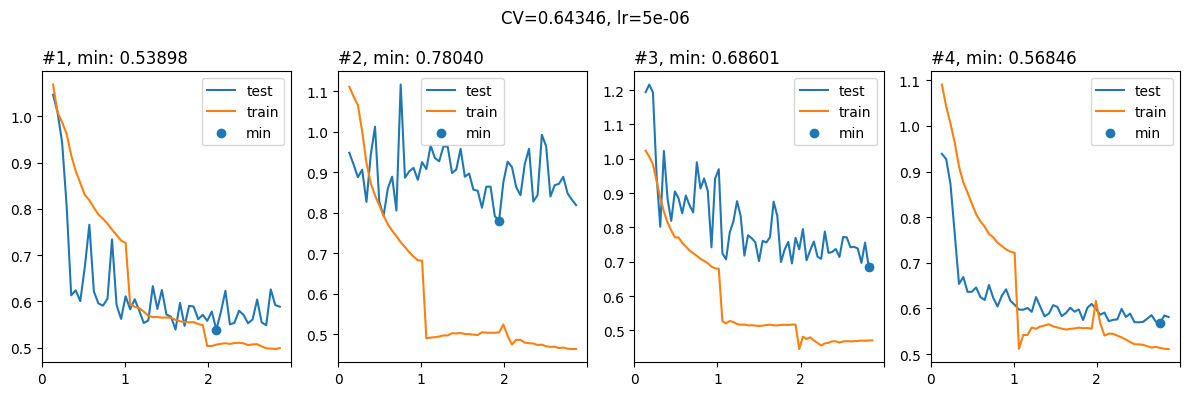

In [19]:
# def cross_validation():
with open(prompts_train_path, encoding='utf-8') as f:
    prompts = pd.read_csv(f)
#     prompts = prompts[prompts.prompt_id != '3b9047'].reset_index(drop=True)
    
plt.figure(figsize=(12,4))

folds_list = list(prompts.prompt_id)
score_type = 'wording'
batch_size = 15
lr = 5e-06
lr_head = 1e-04
weight_decay = 1e-02
n_epochs = 3

scores = []

fig, axs = plt.subplots(1, len(folds_list), figsize=(12,4), layout='tight')

for i, fold in enumerate(folds_list, 1):
    train_loader, test_loader = loaders_init(score_type, batch_size, fold)

    best_score, n_iter, test_losses, train_losses = train_model(n_epochs, lr, weight_decay, i, lr_head)

    scores.append(best_score)

    axs[i-1] = axis_set(axs[i-1])

mean_score = np.mean(scores)

fig.suptitle(f'CV={mean_score:.5f}, lr={lr}')
fig.savefig('res_figure.png', dpi=200)

mean_score

In [20]:
lr0 = 1e-05
a = 0.7
epoch = 3
lr1 = lr0 * a * epoch
# lr1 = lr0 * a**epoch

lr1

2.1e-05

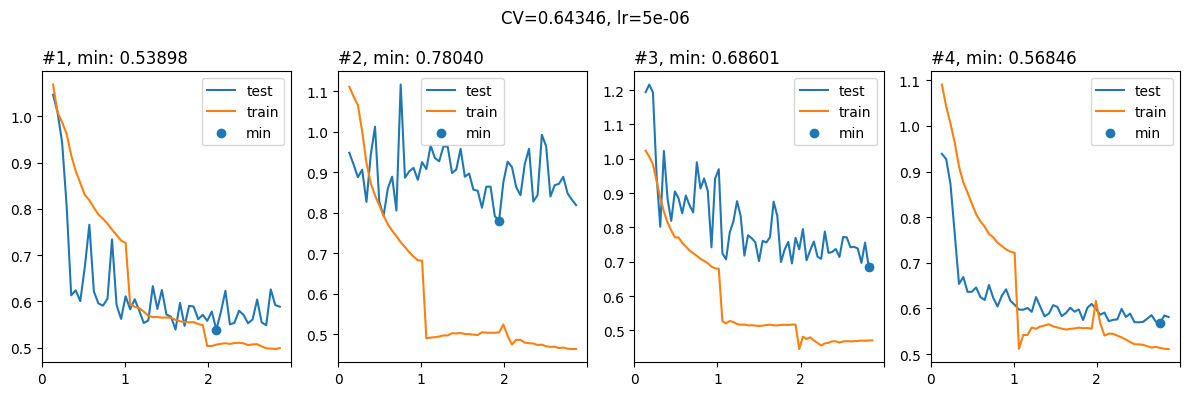

In [21]:
fig